In [1]:
import segyio
import glob
import os
import numpy as np
from time import time
from math import floor

os.environ["CUPY_PYLOPS"] = "0"
from pylops import Spread
from pylops.utils import dottest
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# NMO
---
### CDP-OFFSET seismogramm preparation

In [2]:
folder_path = '/home/spaceswimmer/Documents/NeoGen_Modeling/Results/2D_vankor/Regular'
# folder_path = '/home/artem/Documents/Seismic_modeling/Results/2d_vankor'
sgy_path = glob.glob(folder_path+'/*.sgy')

In [3]:
#Collect all traces from sgy
for i, sgy in enumerate(sgy_path):
    src = segyio.open(sgy, mode='r', endian='big', ignore_geometry=True)
    samples = src.samples
    data = segyio.tools.collect(src.trace[:])
    sou_x = src.attributes(segyio.TraceField.SourceX)[:]/100
    rec_x = src.attributes(segyio.TraceField.GroupX)[:]
    src.close
    if i==0:
        traces = np.empty((len(sgy_path)*data.shape[0],data.shape[1]))
        cdp_x = np.empty(rec_x.shape[0]*len(sgy_path))
        offset =np.empty(rec_x.shape[0]*len(sgy_path))
    traces[data.shape[0]*(i):data.shape[0]*(i+1), :] = data
    cdp_x[rec_x.shape[0]*i:rec_x.shape[0]*(i+1)] = (sou_x+rec_x)/2
    offset[rec_x.shape[0]*i:rec_x.shape[0]*(i+1)] = sou_x-rec_x

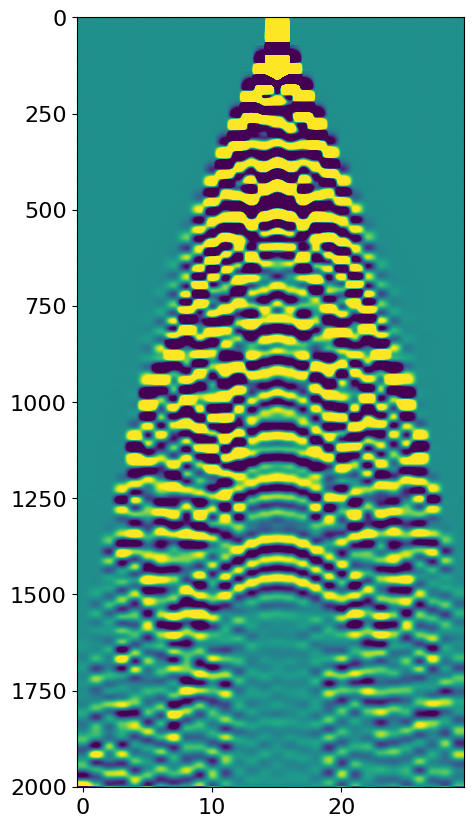

In [4]:
#make cdp seismogram
cdp_ens = {}
cdp_i = 1000
for cdp in np.unique(cdp_x)[cdp_i:cdp_i+1]:
    cdp_idx = cdp_x == cdp
    offset_idx = np.argsort(offset[cdp_idx])
    cdp_sorted = traces[cdp_idx][offset_idx].T
    cdp_ens['cdp'] = cdp_sorted
    cdp_ens['offset'] = offset[cdp_idx][offset_idx]
    cdp_ens['cdp_x'] = np.unique(cdp_x[cdp_idx][offset_idx])[0]


    fig, axs = plt.subplots(figsize=(5,10))
    plt.imshow(cdp_sorted[:,15:45], aspect='auto', vmin=-np.quantile(cdp_sorted, 0.95), vmax = np.quantile(cdp_sorted, 0.95), )
    plt.show()

### Applying NMO with constant velocity

In [5]:
cdp_ens['cdp_x']

np.float64(2500.0)

In [6]:
def create_tables(taxis, haxis, vels_rms):
    dt = taxis[1] - taxis[0]
    ot = taxis[0]
    nt = len(taxis)
    nh = len(haxis)

    # NaN values will be not be spread.
    # Using np.zeros has the same result but much slower.
    table = np.full((nh, nt, nh), fill_value=np.nan)
    dtable = np.full((nh, nt, nh), fill_value=np.nan)

    for ih, h in enumerate(haxis):
        for it0, (t0, vrms) in enumerate(zip(taxis, vels_rms)):
            # Compute NMO traveltime
            tx = np.sqrt(t0**2 + (h / vrms) ** 2)
            it_frac = (tx - ot) / dt
            it_floor = floor(it_frac)
            w = it_frac - it_floor
            # Both it_floor and it_floor + 1 must be valid indices for taxis
            # when using two tables (interpolation).
            if 0 <= it_floor and it_floor + 1 < nt:
                table[ih, it0, ih] = it_floor
                dtable[ih, it0, ih] = w
    return table, dtable


nmo_table, nmo_dtable = create_tables(samples/1000, cdp_ens['offset'], np.ones_like(samples)*2000)

#operator
SpreadNMO = Spread(
    dims=cdp_ens['cdp'].T.shape,  # "Input" shape: NMO-ed data shape
    dimsd=cdp_ens['cdp'].T.shape,  # "Output" shape: original data shape
    table=nmo_table,  # Table of time indices
    dtable=nmo_dtable,  # Table of weights for linear interpolation
    engine="numpy",  # numba or numpy
).H  # To perform NMO *correction*, we need the adjoint
dottest(SpreadNMO, rtol=1e-4)

np.True_

In [7]:
#summon operator
dnmo_spr = SpreadNMO @ cdp_ens['cdp'].T

start = time()
SpreadNMO @ cdp_ens['cdp'].T
end = time()

print(f"Ran in {1e6*(end-start):.0f} μs")

Ran in 1400975 μs


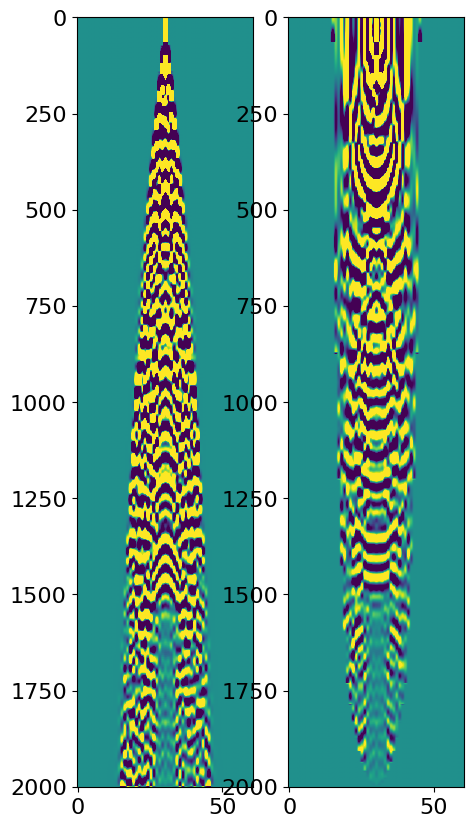

In [8]:
# Plot Data and NMO-corrected data
fig, axs = plt.subplots(1, 2, figsize=(5,10))
axs[0].imshow(cdp_ens['cdp'], aspect='auto', vmin=-np.quantile(cdp_ens['cdp'], 0.9), vmax = np.quantile(cdp_ens['cdp'], 0.9), )
axs[1].imshow(dnmo_spr.T, aspect='auto', vmin=-np.quantile(dnmo_spr, 0.9), vmax = np.quantile(dnmo_spr, 0.9), )

### NMO with model velocities

In [ ]:
def nn_interp_coords(data: np.ndarray, origin: tuple, domain_size : tuple, spacing : tuple, dim_vectors : tuple):
    X, Z = [np.arange(o, ds, step=sp, dtype='float') for o, ds, sp in zip(origin, domain_size, spacing)]
    Z, X = np.meshgrid(Z, X)
    interp = RegularGridInterpolator(dim_vectors, data,
                                     method='nearest',
                                     # method='linear', # Linear артефачит
                                    )
    new_value = interp((X, Z))

    return new_value

In [ ]:
sgy_path = 'Data/Models/NMO/Vp 2D 1.sgy'
src = segyio.open(sgy_path, mode='r', endian='big', ignore_geometry=True)
model = {'z': src.samples}
model['vp_data'] = segyio.tools.collect(src.trace[:])
sou_x = src.attributes(segyio.TraceField.SourceX)[:]
sou_z = src.attributes(segyio.TraceField.SourceSurfaceElevation)[:]
rec_x = src.attributes(segyio.TraceField.GroupX)[:]
rec_z = src.attributes(segyio.TraceField.ReceiverGroupElevation)[:]
model['x'] = np.cumsum(np.sqrt(np.diff(cdp_x, prepend=cdp_x[0])**2+np.diff(cdp_y, prepend=cdp_y[0])**2))/10
src.close()

vp_data_int = nn_interp_coords(model['vp_data'], (0,0), (el_pars['x'].max(), el_pars['z'].max()), spacing, dim_vectors)

NameError: name 'cdp_y' is not defined

# RTM Migration
---

In [42]:
!python Scripts/RTM.py

TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
Model creation finished in: 2.5050103664398193 sec
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeFunction [u(time, x, y)] assumed to fit the GPU memory
TimeF